In [1]:
from regression_toolbox.model import Model, add_model, delete_model
from regression_toolbox.likelihood import Likelihood
from regression_toolbox.parameter import Parameter
from visualisation_toolbox.domain import Domain
from regression_toolbox.sampler import Sampler
from visualisation_toolbox.visualiser import Visualiser
from data_processing.sim_data_processor import SimDataProcessor
from data_processing.raw_data_processor import RawDataProcessor
import numpy as np
import pandas as pd
import os

os.chdir('/PhD_project/')

/build/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I_y: 0.010, I_z: 0.500, C: 8680021686.60434
I_y: 0.112, I_z: 0.045, C: 8270087554.48676
I_y: 0.214, I_z: 0.023, C: 7355017108.46094
I_y: 0.316, I_z: 0.016, C: 6299707122.91128
I_y: 0.417, I_z: 0.012, C: 5419468280.52196
I_y: 0.519, I_z: 0.010, C: 4844258360.57563
I_y: 0.621, I_z: 0.008, C: 4540229413.37843
I_y: 0.723, I_z: 0.007, C: 4408157166.72467
I_y: 0.825, I_z: 0.006, C: 4360569707.99078
I_y: 0.927, I_z: 0.005, C: 4346266161.68121
I_y: 1.028, I_z: 0.005, C: 4342666018.49696
I_y: 1.130, I_z: 0.004, C: 4341905211.70758
I_y: 1.232, I_z: 0.004, C: 4341769960.44313
I_y: 1.334, I_z: 0.004, C: 4341749705.06302
I_y: 1.436, I_z: 0.003, C: 4341747146.81461
I_y: 1.538, I_z: 0.003, C: 4341746874.09711
I_y: 1.639, I_z: 0.003, C: 4341746849.54223
I_y: 1.741, I_z: 0.003, C: 4341746847.67393
I_y: 1.843, I_z: 0.003, C: 4341746847.55375
I_y: 1.945, I_z: 0.003, C: 4341746847.54722
I_y: 2.047, I_z: 0.002, C: 4341746847.54692
I_y: 2.149, I_z: 0.002, C: 4341746847.54691
I_y: 2.250, I_z: 0.002, C: 43417

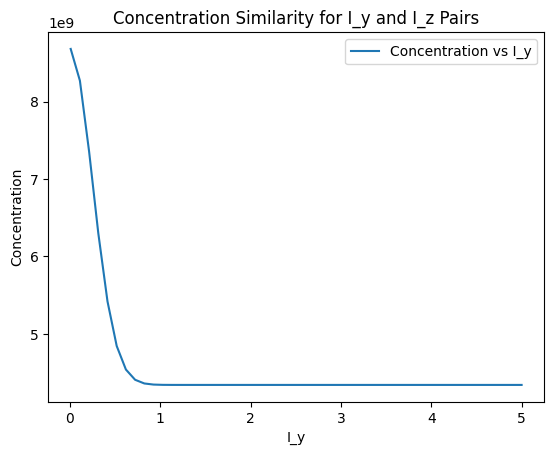

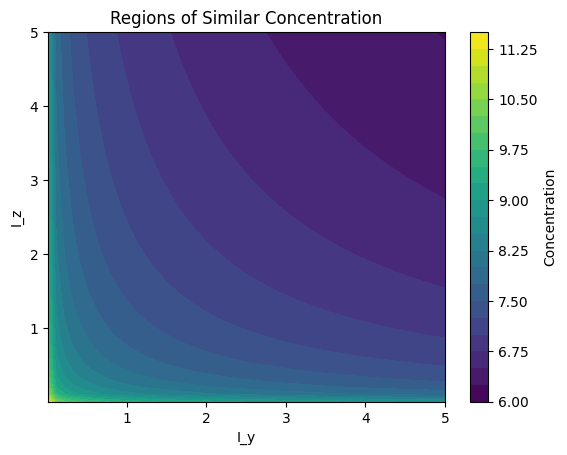

In [2]:
import numpy as np

# Gaussian Plume Function
def gaussian_plume(I_y, I_z, x, y, z, Q, u, H):
    sigma_y = I_y * x
    sigma_z = I_z * x
    exp_y = np.exp(-y**2 / (2 * sigma_y**2))
    exp_z = np.exp(-(z - H)**2 / (2 * sigma_z**2)) + np.exp(-(z + H)**2 / (2 * sigma_z**2))
    return (Q / (2 * np.pi * sigma_y * sigma_z * u)) * exp_y * exp_z

# Fixed parameters
x, y, z = 500, 0, 5
Q, u, H = 3.41e13, 1, 5
constant = 0.005  # I_y * I_z = constant

# Generate pairs of I_y and I_z
I_y_values = np.linspace(0.01, 5, 50)
I_z_values = constant / I_y_values  # I_y * I_z = constant

# Compute concentrations
concentrations = [gaussian_plume(Iy, Iz, x, y, z, Q, u, H) for Iy, Iz in zip(I_y_values, I_z_values)]

# Compare results
for Iy, Iz, C in zip(I_y_values, I_z_values, concentrations):
    print(f"I_y: {Iy:.3f}, I_z: {Iz:.3f}, C: {C:.5f}")


import matplotlib.pyplot as plt

plt.plot(I_y_values, concentrations, label="Concentration vs I_y")
plt.xlabel("I_y")
plt.ylabel("Concentration")
plt.title("Concentration Similarity for I_y and I_z Pairs")
plt.legend()
plt.show()

I_y_grid, I_z_grid = np.meshgrid(np.linspace(0.01, 5, 50), np.linspace(0.01, 5, 50))
C_grid = np.array([
    gaussian_plume(Iy, Iz, x, y, z, Q, u, H) for Iy, Iz in zip(I_y_grid.flatten(), I_z_grid.flatten())
]).reshape(I_y_grid.shape)

plt.contourf(I_y_grid, I_z_grid, np.log10(C_grid), levels=20, cmap="viridis")
plt.colorbar(label="Concentration")
plt.xlabel("I_y")
plt.ylabel("I_z")
plt.title("Regions of Similar Concentration")
plt.show()



sample: 100%|██████████| 15000/15000 [00:11<00:00, 1325.30it/s, 103 steps of size 6.94e-03. acc. prob=0.93]


{'I_y': Array(0.49650425, dtype=float32), 'I_z': Array(0.50349456, dtype=float32)}


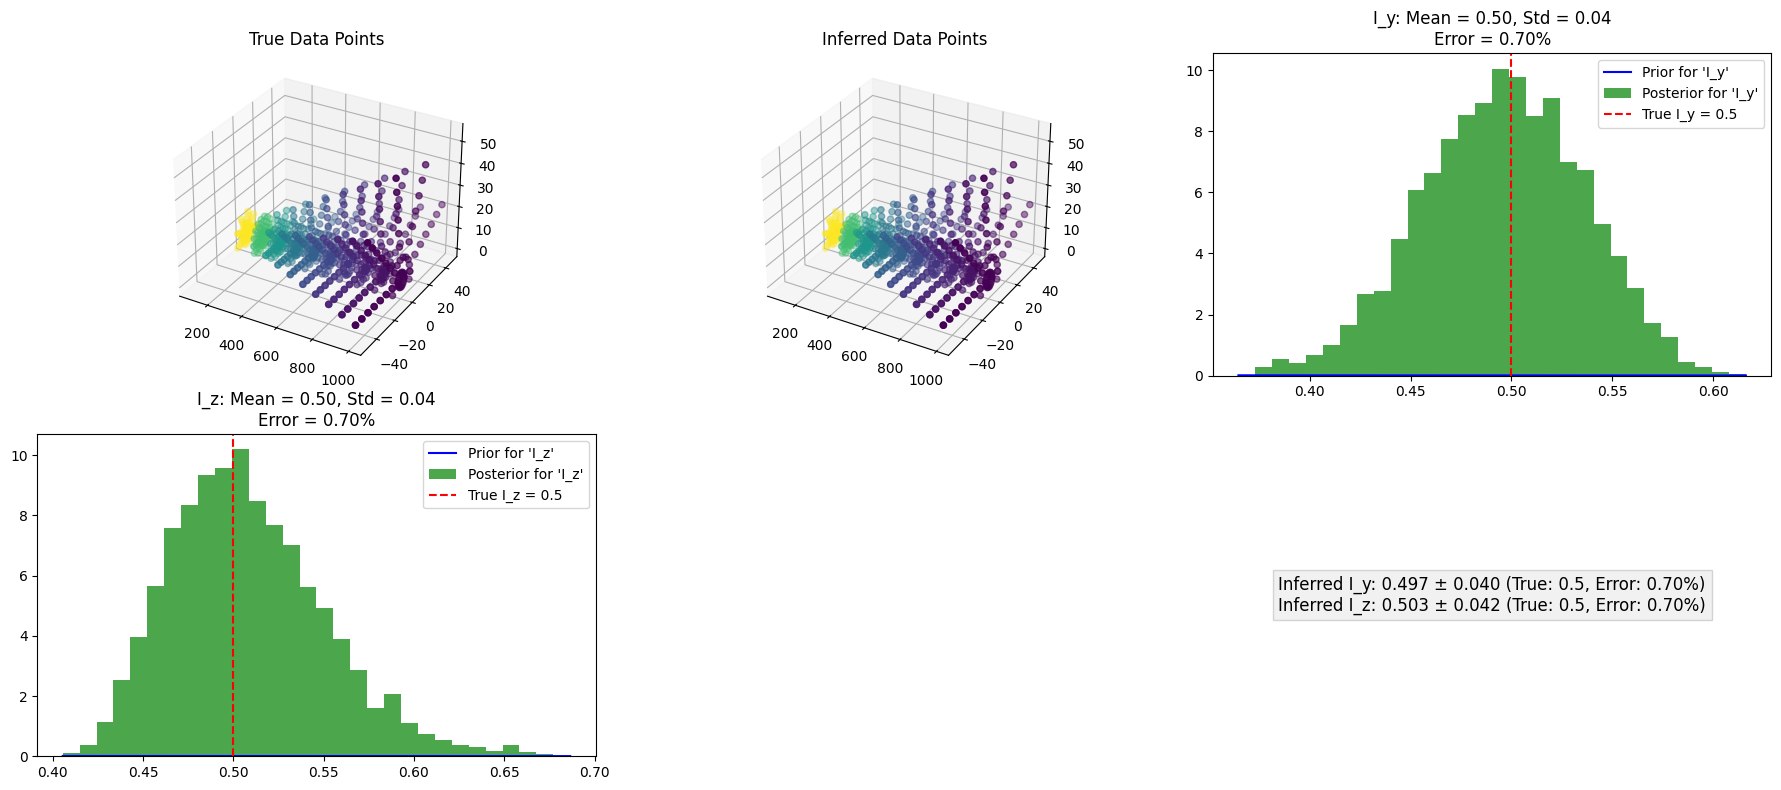

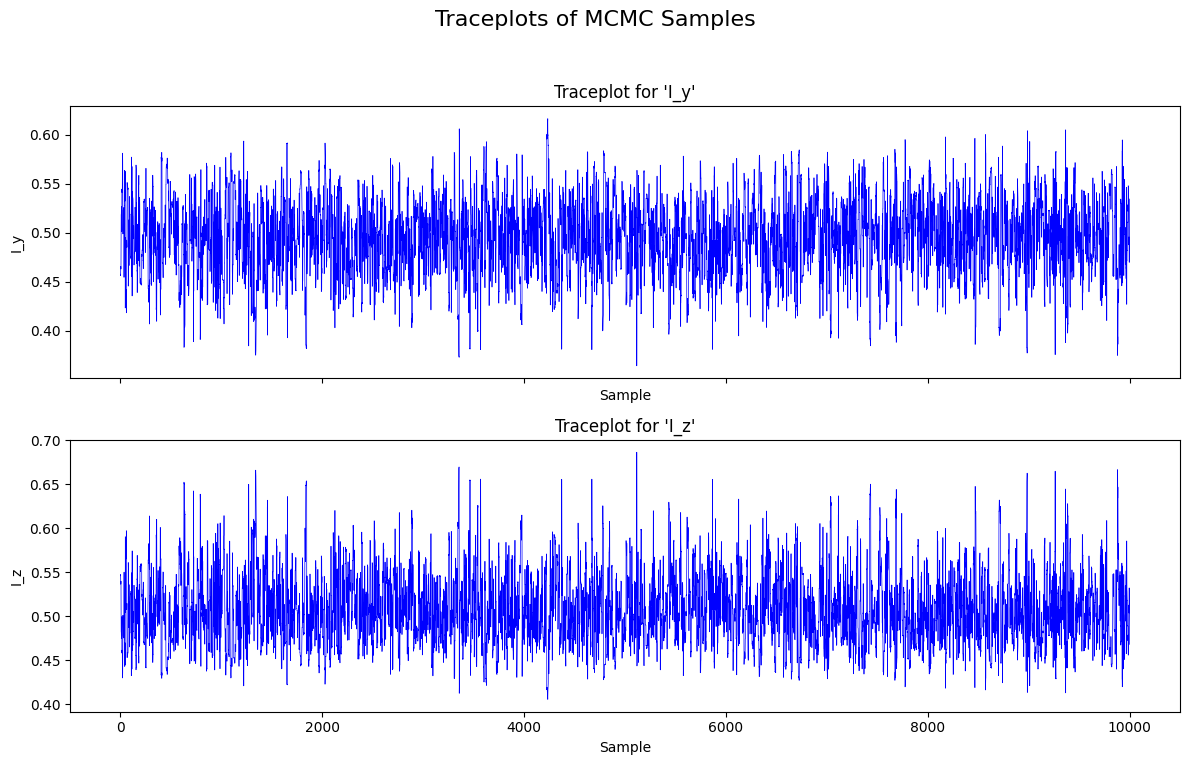

In [16]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import numpy as np

seed = 42
# Set the seed for numpy
np.random.seed(seed)

# PARAMETERS
n_samples = 10            # Number of data samples (per dimension for 2D/3D)
noise_scale = 0.01            # Noise scale for data generation
num_warmup = 5000            # Number of warmup steps for MCMC
num_samples = 10000        # Number of MCMC samples
model_name = 'GPM'    # Set to 'line', 'curve', 'simple_2D', or 'complex_2D'
dim = 3  # Set to 1, 2, or 3 for dimensionality

# TRUE VALUES FOR PARAMETERS
# true_params = {'a': 2.5, 'b': 1.5}# 'c': 3.5, 'd': 4.5, 'e': 5.5, 'f': 6.5}

true_params = {'I_y': .5, 'I_z': .5}# 'c': 3.5, 'd': 4.5, 'e': 5.5, 'f': 6.5}


# PRIOR HYPERPARAMETERS
prior_distributions = {
    'I_y': dist.LogNormal(0.01, 100),
    'I_z': dist.LogNormal(0.01, 100),
    # 'sigma': dist.Exponential(1.0),
    # 'c': dist.Normal(3.5, 1),
    # 'd': dist.Normal(4.5, 1),
    # 'e': dist.Normal(5.5, 1),
    # 'f': dist.Normal(6.5, 1)
}


# Model functions for different cases
def line_model(x, a, b):
    return a * x + b

def curve_model(x, a, b, c):
    return a * x ** b + c

def simple_2D_model(x, y, a, b):
    return a * x + b * y

def complex_2D_model(x, y, a, b, c, d):
    return a * x ** b + c * y ** d

def simple_3D_model(x, y, z, a, b, c):
    return a * x + b * y + c * z

def complex_3D_model(x, y, z, a, b, c, d, e, f):
    return a * x ** b + c * y ** d + e * z ** f

def normalised_gaussian_plume_model(x, y, z, I_y, I_z):
    Q = 3.41e13
    H = 5
    return jnp.log10(Q / (2 * np.pi * I_y * I_z * x**2) * jnp.exp(-0.5 * ((y / (I_y*x)) ** 2))*(jnp.exp(-0.5 * (((z-H) / (I_z*x)) ** 2))+jnp.exp(-0.5 * (((z+H) / (I_z*x)) ** 2))))


# Generalized model function
def example_model_func(*coords, **params):
    if len(coords) == 1:    # 1D model
        x = coords[0]
        if model_name == 'line':
            return line_model(x, params['a'], params['b'])
        if model_name == 'curve':
            return curve_model(x, params['a'], params['b'], params['c'])
    elif len(coords) == 2:  # 2D model
        x, y = coords
        if model_name == 'simple_2D':
            return simple_2D_model(x, y, params['a'], params['b'])
        if model_name == 'complex_2D':
            return complex_2D_model(x, y, params['a'], params['b'], params['c'], params['d'])
    elif len(coords) == 3:  # 3D model
        x, y, z = coords
        if model_name == 'simple_3D':
            return simple_3D_model(x, y, z, params['a'], params['b'], params['c'])
        if model_name == 'GPM':
            return normalised_gaussian_plume_model(x, y, z, params['I_y'], params['I_z'])
    else:
        raise ValueError("Invalid number of dimensions")
    

def generate_cone():
    # Parameters
    n_samples = 10  # Number of samples along each dimension

    # Create a filled cone along the x-axis
    theta = np.linspace(0, 2 * np.pi, n_samples)  # Angular coordinates
    x = np.linspace(100, 1000, n_samples)  # X coordinates from tip to base of the cone

    # Initialize lists to hold the filled cone points
    X_cone = []
    Y_cone = []
    Z_cone = []

    for xi in x:
        max_radius = (5 - xi) / 20  # Radius decreases linearly from 1 at the base to 0 at the tip
        r = np.linspace(10, max_radius, n_samples)  # Radial distances within this cross-section
        Theta, R = np.meshgrid(theta, r)  # Create a grid in polar coordinates for each slice
        
        # Convert polar to Cartesian coordinates for each cross-section
        X_cone.append(np.full_like(R, xi))  # X coordinate is fixed for this slice
        Y_cone.append(R * np.cos(Theta))
        Z_cone.append(R * np.sin(Theta))

    # Convert lists to arrays and flatten to get full 3D point coordinates
    X_cone = np.concatenate(X_cone).flatten()
    Y_cone = np.concatenate(Y_cone).flatten()
    Z_cone = np.concatenate(Z_cone).flatten()

    # Translate the cone to have its tip at (0, 0, 5)
    X_cone += 0  # No change needed, but kept for clarity
    Y_cone += 0
    Z_cone += 5

    # Filter out points where Z <= 0
    mask = Z_cone > 0
    X_cone = X_cone[mask]
    Y_cone = Y_cone[mask]
    Z_cone = Z_cone[mask]

    return X_cone, Y_cone, Z_cone

# Step 1: Generate synthetic data
def generate_data(model_func, params, n_samples=50, noise_scale=1, dim=2):
    if dim == 1:
        x = np.linspace(0.1, 10, n_samples)
        C_true = model_func(x, **params)
        vec_noise = noise_scale*np.ones(x.shape)
        C = np.array([C_true[i] + vec_noise[i]**2*np.random.normal() for i in range(C_true.size)])
        return (x,), C
    
    elif dim == 2:
        x = np.linspace(0.1, 10, n_samples)
        y = np.linspace(0.1, 10, n_samples)
        X, Y = np.meshgrid(x, y)
        C = model_func(X, Y, **params) + noise_scale**2 * np.random.normal(X.shape)
        return (X, Y), C

    elif dim == 3:
        X, Y, Z = generate_cone()
        C_true = model_func(X, Y, Z, **params)
        vec_noise = noise_scale*np.ones(C_true.size)
        C = np.array([C_true[i] + vec_noise[i]**2*np.random.normal() for i in range(C_true.size)])
        return (X, Y, Z), C

# Step 2: Bayesian model definition
def generalized_model(*coords, C=None, model_func=None, prior_distributions=None):
    params = {name: numpyro.sample(name, prior) for name, prior in prior_distributions.items() if name != 'sigma'}
    # sigma = numpyro.sample('sigma', prior_distributions['sigma'])
    C_pred = model_func(*coords, **params)
    with numpyro.plate('data', len(C)):
        numpyro.sample('obs', dist.Normal(C_pred, 0.01), obs=C)

# Step 3: Run inference
def run_inference(coords, C, model_func, prior_distributions, num_warmup=500, num_samples=1000):
    kernel = NUTS(lambda *coords: generalized_model(*coords, C=C, model_func=model_func, prior_distributions=prior_distributions))
    with numpyro.validation_enabled():
        mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
    rng_key = jax.random.PRNGKey(0)
    mcmc.run(rng_key, *coords)
    return mcmc.get_samples()

# Generate synthetic data
coords, C_data = generate_data(example_model_func, true_params, n_samples, noise_scale, dim)
# Perform Bayesian inference
samples = run_inference(coords, C_data, example_model_func, prior_distributions, num_warmup, num_samples)

# Extract posterior samples and calculate inferred values
posterior_params = {name: samples[name] for name in prior_distributions.keys()}
inferred_means = {name: jnp.percentile(param_samples,50) for name, param_samples in posterior_params.items()}
inferred_stds = {name: jnp.std(param_samples) for name, param_samples in posterior_params.items()}
errors = {name: abs((inferred_means[name] - true_params[name]) / true_params[name]) * 100 if name in true_params else None
          for name in inferred_means}

# Step 4: Plot results
num_posteriors = len(posterior_params)
total_plots = num_posteriors + dim + 1  # n for prediction, one for summary
num_cols = 3
num_rows = (total_plots + num_cols - 1) // num_cols  # Rows needed for a 3-column layout

fig = plt.figure(figsize=(18, num_rows * 4))
gs = fig.add_gridspec(num_rows, num_cols)

post_start_grid = 0

# Plot prediction plot
if dim == 1:
    x = coords[0]
    C_true = example_model_func(x, **true_params)
    C_inferred = example_model_func(x, **inferred_means)
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(x, C_inferred, label="Inferred", color='green')
    ax0.plot(x, C_true, label="True", color='blue')
    ax0.set_title("True vs Inferred Predictions")
    ax0.set_xlabel("x")
    ax0.set_ylabel("y")
    ax0.legend()
    post_start_grid = 1

elif dim == 2:
    X, Y = coords
    C_true = example_model_func(X, Y, **true_params)
    C_inferred = example_model_func(X, Y, **inferred_means)
    ax0 = fig.add_subplot(gs[0, 0])
    im0 = ax0.pcolor(X, Y, C_true, cmap='viridis')
    ax0.set_title("True Surface")
    fig.colorbar(im0, ax=ax0)
    ax1 = fig.add_subplot(gs[0, 1])
    im1 = ax1.pcolor(X, Y, C_inferred, cmap='viridis')
    ax1.set_title("Inferred Surface")
    fig.colorbar(im1, ax=ax1)
    post_start_grid = 2

elif dim == 3:
    X, Y, Z = coords
    C_true = example_model_func(X, Y, Z, **true_params)
    C_inferred = example_model_func(X, Y, Z, **inferred_means)
    ax0 = fig.add_subplot(gs[0, 0], projection='3d')
    ax0.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=C_true.flatten(), cmap='viridis', marker='o')
    ax0.set_title("True Data Points")
    ax1 = fig.add_subplot(gs[0, 1], projection='3d')
    ax1.scatter(X.flatten(), Y.flatten(), Z.flatten(), c=C_inferred.flatten(), cmap='viridis', marker='o')
    ax1.set_title("Inferred Data Points")
    post_start_grid = 2

# Plot posterior distributions
for i, (name, samples) in enumerate(posterior_params.items()):
    ax = fig.add_subplot(gs[(i + post_start_grid) // num_cols, (i + post_start_grid) % num_cols])
    x = np.linspace(jnp.min(samples), jnp.max(samples), 100)
    prior_dist = prior_distributions[name]
    prior_pdf = np.exp(prior_dist.log_prob(x)) if name != 'sigma' else np.exp(-prior_dist.rate * x)
    ax.plot(x, prior_pdf, label=f"Prior for '{name}'", color='blue')
    ax.hist(samples, bins=30, density=True, alpha=0.7, label=f"Posterior for '{name}'", color='green')
    true_val = true_params.get(name, None)
    if true_val is not None:
        ax.axvline(true_val, color='red', linestyle='--', label=f"True {name} = {true_val}")
    mean, std = inferred_means[name], inferred_stds[name]
    error_text = f"Error = {errors.get(name, 'N/A'):.2f}%" if errors.get(name) is not None else ""
    ax.set_title(f"{name}: Mean = {mean:.2f}, Std = {std:.2f}\n{error_text}")
    ax.legend()

# Add summary text in its own plot
summary_text = "\n".join(
    [f"Inferred {name}: {inferred_means[name]:.3f} ± {inferred_stds[name]:.3f} (True: {true_params.get(name, 'N/A')}, Error: {errors[name]:.2f}%)"
     for name in inferred_means if name in true_params]
)

print(inferred_means)
text_ax = fig.add_subplot(gs[num_rows-1, num_cols-1])
text_ax.text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=12,
             bbox=dict(facecolor='lightgrey', alpha=0.3, edgecolor='gray'))
text_ax.axis("off")

plt.tight_layout()
plt.show()

# Plot traceplots of the samples for each parameter
fig, axes = plt.subplots(len(posterior_params), 1, figsize=(12, 4 * len(posterior_params)), sharex=True)
fig.suptitle("Traceplots of MCMC Samples", fontsize=16)

for i, (name, samples) in enumerate(posterior_params.items()):
    ax = axes[i] if len(posterior_params) > 1 else axes  # Adjust for single parameter case
    ax.plot(samples, lw=0.5, color='blue')
    ax.set_title(f"Traceplot for '{name}'")
    ax.set_ylabel(name)
    ax.set_xlabel("Sample")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()